In [48]:
from textblob import Word
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [12]:
TRAIN_PATH = './train'
TEST_PATH = './test'

classes = {'pos': 0, 'neg': 1}

In [18]:
def make_data(mode='train'):
    data = []
    for _class in classes:
        if mode == 'train':
            path = os.path.join(TRAIN_PATH, _class)
        elif mode == "test":
            path = os.path.join(TEST_PATH, _class)
        for file in os.listdir(path):
            this_file = open(os.path.join(path, file), "r", encoding="utf8").read()
            data.append([this_file, _class])
    return data

In [19]:
train_data = make_data(mode='train')
test_data = make_data(mode='test')

In [23]:
import random
random.shuffle(train_data)
random.shuffle(test_data)

In [24]:
train_data_content = [i[0] for i in train_data]
train_data_class = [classes[i[1]] for i in train_data]

test_data_content = [i[0] for i in test_data]
test_data_class = [classes[i[1]] for i in test_data]

In [26]:
train = pd.DataFrame()
test = pd.DataFrame()

In [28]:
train['comment'] = train_data_content
train['review'] = train_data_class

test['comment'] = test_data_content
test['review'] = test_data_class

In [32]:
# we converted the given text docs to DataFrames for eaasier preprocessing

train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

In [34]:
import re
stop_words = stopwords.words('english')

train['comment'] = train['comment'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
train['comment'] = train['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

In [39]:
# removing punctuations
train['comment'] = train['comment'].str.replace('[^\w\s]', '')
train.head()

,comment,review
0,grew watching inspector gadget was still is on...,1
1,anarchy lawlessness reign supreme podunk hick ...,0
2,documentary makes travel around globe contains...,0
3,everyone knows zero day event think movie elep...,0
4,begin spoiler fitfully funny memorable mr chon...,1


In [40]:
test['comment'] = test['comment'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
test['comment'] = test['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
test['comment'] = test['comment'].str.replace('[^\w\s]', '')
test.head()

,comment,review
0,sit basement light hour half thats watching su...,1
1,spoof films require pure stupidity lack sort i...,1
2,movie like come along often im surprised took ...,0
3,paranoid park alex 16 year old skater causes d...,1
4,ok maybe posse cant compare popular cowboywest...,0


In [41]:
# lemmatizing the words
train['comment'] = train['comment'].apply(lambda x: ' '.join(Word(x).lemmatize() for x in x.split()))
test['comment'] = test['comment'].apply(lambda x: ' '.join(Word(x).lemmatize() for x in x.split()))

In [42]:
total_data = train.append(test, ignore_index=True)
total_data.head()

,comment,review
0,grew watching inspector gadget wa still is one...,1
1,anarchy lawlessness reign supreme podunk hick ...,0
2,documentary make travel around globe contains ...,0
3,everyone know zero day event think movie eleph...,0
4,begin spoiler fitfully funny memorable mr chon...,1


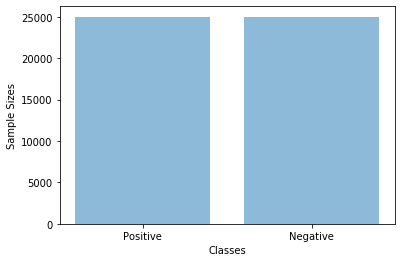

In [52]:
pos = total_data[total_data['review'] == 0].shape[0]
neg = total_data[total_data['review'] == 1].shape[0]

plt.bar(range(2), [pos, neg], alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Sample Sizes')
plt.xticks(range(2), ['Positive', 'Negative'])
plt.show()

In [54]:
# the test and train sample sizes are equal so we are going to mix these
# data samples and split them into train and test samples
train, test = train.shape[0], test.shape[0]

In [258]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_t, y_v = train_test_split(total_data['comment'], 
                                              total_data['review'],
                                              test_size=0.2,
                                              random_state=42)

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500, lowercase=True, analyzer='word', stop_words='english', ngram_range=(1, 1))
tfidf.fit(total_data['comment'])

x_t = tfidf.transform(x_train)
x_v = tfidf.transform(x_valid)

In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [261]:
x_t = torch.from_numpy(x_t.todense())
x_v = torch.from_numpy(x_v.todense())

In [262]:
y_t_ = torch.Tensor([np.eye(2)[i] for i in np.array(y_t)])
y_v_ = torch.Tensor([np.eye(2)[i] for i in np.array(y_v)])

In [263]:
y_t = y_t_
y_v = y_v_

In [264]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(500, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        x = F.log_softmax(self.classifier(x), dim=1)
        return x

In [265]:
net = Net()
net

Net(
  (classifier): Sequential(
    (0): Linear(in_features=500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [266]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [267]:
EPOCHS = 5
BATCH_SIZE = 128

from tqdm import tqdm

epochs_loss = []

for epoch in range(EPOCHS):
    print('Epoch', epoch + 1)
    for i in tqdm(range(0, x_t.shape[0], BATCH_SIZE)):
        batch_data_x = x_t[i:i+BATCH_SIZE].view(-1, 500).float()
        batch_data_y = y_t[i:i+BATCH_SIZE].float()
        
        net.zero_grad()
        
        output = net(batch_data_x)
        loss = loss_function(output, batch_data_y)
        epochs_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print('Epoch Loss', loss.item(), '\n')

  4%|█▊                                                | 11/313 [00:00<00:02, 109.24it/s]

Epoch 1


  9%|████▍                                             | 28/313 [00:00<00:02, 131.93it/s]

Epoch Loss 1.610074758529663 

Epoch 2


  2%|█▏                                                  | 7/313 [00:00<00:04, 67.49it/s]

Epoch Loss 1.5969319343566895 

Epoch 3


  4%|██                                                | 13/313 [00:00<00:02, 122.97it/s]

Epoch Loss 1.5703330039978027 

Epoch 4


  4%|██                                                | 13/313 [00:00<00:02, 121.82it/s]

Epoch Loss 1.5663179159164429 

Epoch 5


100%|█████████████████████████████████████████████████| 313/313 [00:02<00:00, 112.51it/s]

Epoch Loss 1.5629926919937134 



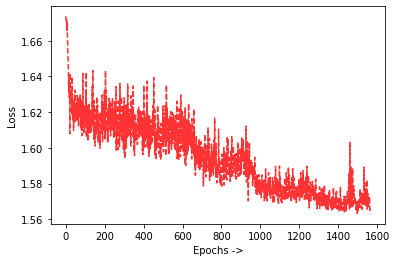

In [268]:
plt.plot(epochs_loss, 'r--', label='Epoch Loss', alpha=0.8)
plt.xlabel('Epochs ->')
plt.ylabel('Loss')
plt.show()

In [269]:
with torch.no_grad():
    output = net(x_v.view(-1, 500).float())
    correct = 0
    total = 0
    for i in range(output.shape[0]):
        if torch.argmax(output[i]) == torch.argmax(y_v[i]):
            correct += 1
        total += 1
    
    print('Validation Accuracy', round(correct/total * 100.0, 4), '%')

Validation Accuracy 81.75 %


In [190]:
# the validation accuracy obtained isn't quite great
# let's check with other traditional models

In [218]:
def model_training(clf, x_t, y_t, x_v=None , y_v=None ,task='binary:logistic'):
    clf.fit(x_t,y_t)
    print('training accuracy', clf.score(x_t,y_t))
    
    if task=='binary:logistic':
      print('validation accuracy', clf.score(x_v,y_v))
      print('validation f1_score',f1_score(clf.predict(x_v),y_v))
      print('validation roc_auc score',roc_auc_score(y_v,clf.predict_proba(x_v)[::,-1]))
      print('confusion matrix \n',confusion_matrix(y_v, clf.predict(x_v)))
    
    if task=='reg:linear':
        if x_v!=None:
            print('validation r2_score', clf.score(x_v,y_v))
            print('validation MSE',mean_squared_error(clf.predict(x_v),y_v))

            
    return clf

In [220]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, accuracy_score

xgb = XGBClassifier(n_estimators=500, max_depth=5,learning_rate=0.1,scale_pos_weight=1.4266790777602751)
lgr = LogisticRegression(n_jobs=1)

In [224]:
x_t_ = x_t.data.numpy()
x_v_ = x_v.data.numpy()

y_t_ = [list(dat).index(1) for dat in y_t.data.numpy()]
y_v_ = [list(dat).index(1) for dat in y_v.data.numpy()]

In [227]:
xgb = model_training(xgb, x_t_, y_t_, x_v_, y_v_)
lgr = model_training(lgr, x_t_, y_t_, x_v_, y_v_)

training accuracy 0.91855
validation accuracy 0.8203
validation f1_score 0.8255847811317092
validation roc_auc score 0.9094717578870316
confusion matrix 
 [[3950 1060]
 [ 737 4253]]
training accuracy 0.84015
validation accuracy 0.8314
validation f1_score 0.8292485314968604
validation roc_auc score 0.9138150952603811
confusion matrix 
 [[4220  790]
 [ 896 4094]]


In [228]:
# Looks like XGBoost is overfitting the data, for this dataset looks like
# Logistic Regression is doing a better job for us

In [229]:
import pickle

pickle.dump(lgr, open("model/lgr.pickle", "wb"))
pickle.dump(xgb, open("model/xgb.pickle", "wb"))

In [271]:
pickle.dump(net, open("model/net_trained.pickle", "wb"))

C:\ProgramData\Anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [270]:
torch.save(net, open("model/net.pt", "wb"))

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# To load the pytorch model
# model = torch.load(PATH)
# model.eval()